# This notebook is the implementation of:
- OpenAI's GPT-4o
- Meta's Llama 3.3 70B
- BERT w chunking
- Longformer w chunking

MISMATCH: File: dbs-annual-report-2023-risk-management_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_management, Llama: risk_management
MISMATCH: File: Credit Risk_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_management, Llama: risk_management
MISMATCH: File: Consumer Credit Report_Updated_30_Oct_2024_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: consumer_finance, Llama: consumer_finance
MISMATCH: File: finanalysis_sample_reports_cleaned.txt, Expected: investments_market_research, GPT-4o: financial_statements, Llama: financial_statements
MISMATCH: File: mom_sb_cleaned.txt, Expected: loans, GPT-4o: employment, Llama: employment
MISMATCH: File: mom_sb_mw_cleaned.txt, Expected: loans, GPT-4o: employment, Llama: loans
MISMATCH: File: The_Singapore_Code_on_Take_Overs_and_Merger_24 January 2019_cleaned.txt, Expected: partnerships, GPT-4o: financial_regulations, Llama: risk_assessment_reports_frameworks
MISMATCH: File: 

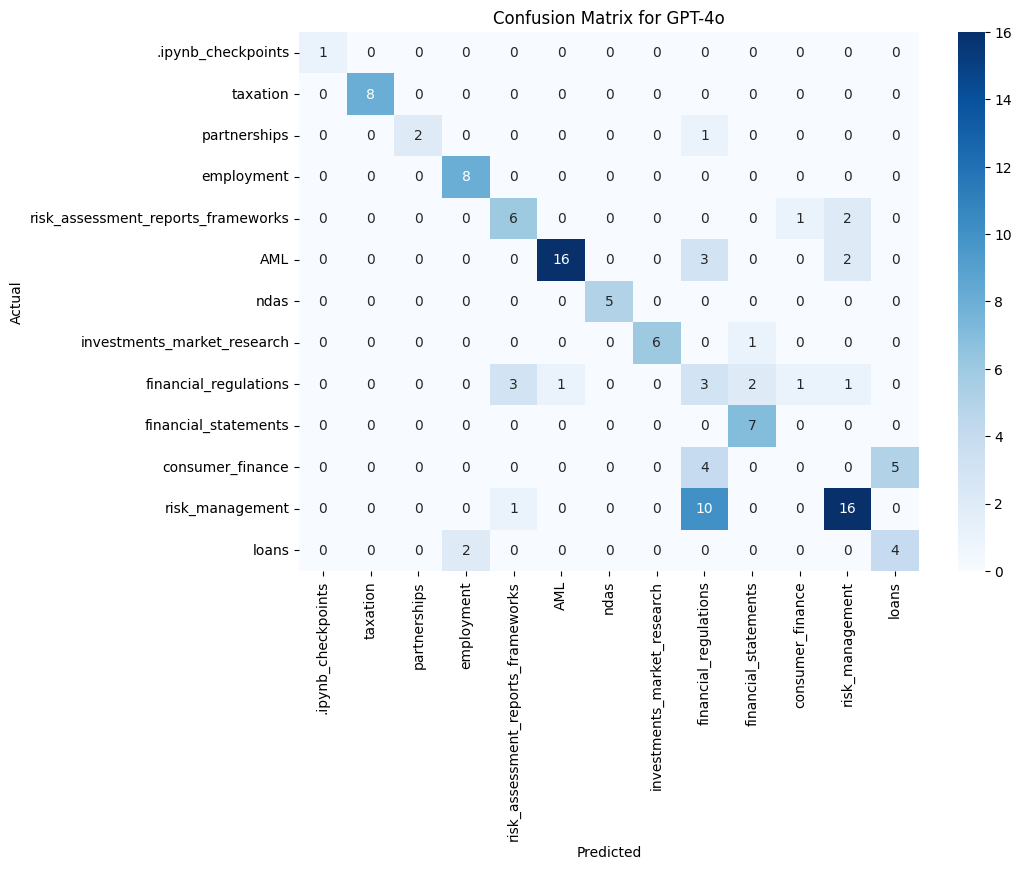

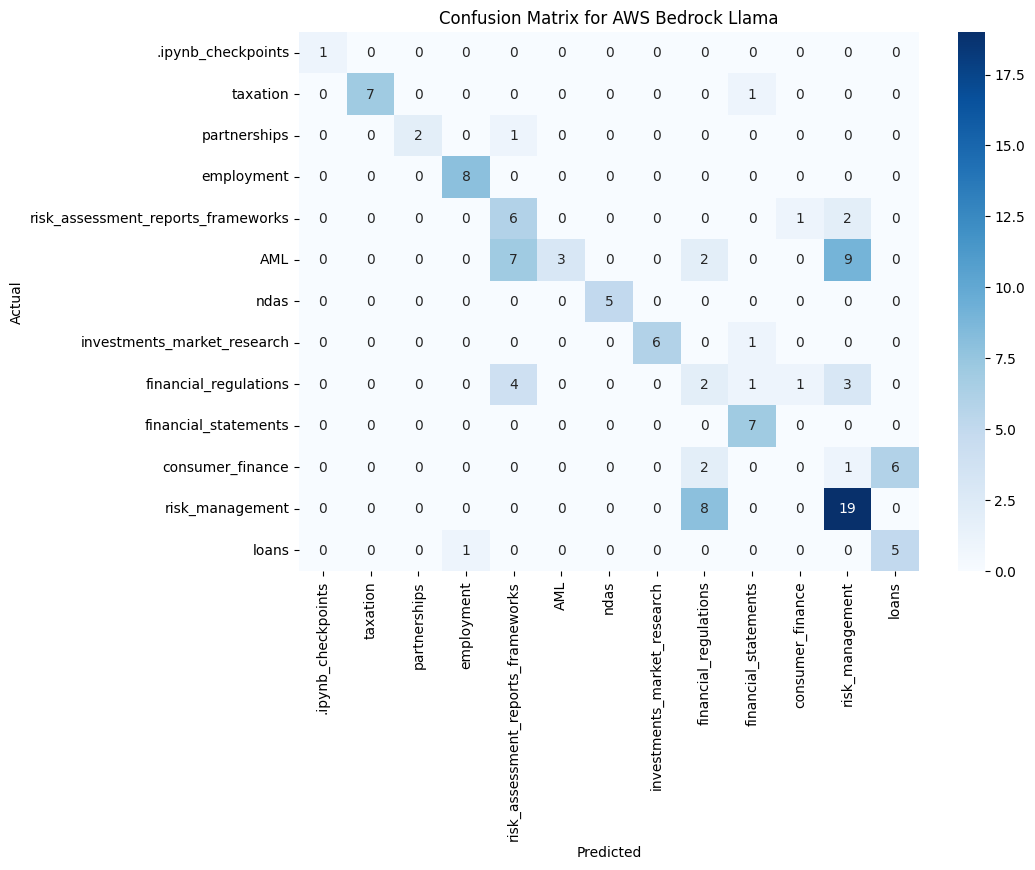

In [24]:
import os
import pandas as pd
import json
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from botocore.config import Config
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables
load_dotenv("codes.env")

# Set up AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")

# Create a Bedrock Runtime client
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# OpenAI client setup
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# Load the mapping CSV file
mapping_file_path = 'file_topic_mapping.csv'
data_folder_path = 'W2_Cleaned_Data'  # Root folder containing topic directories

# Load the file-topic mapping CSV
file_topic_mapping = pd.read_csv(mapping_file_path)

# Extract unique topics from the CSV
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# AWS Bedrock Llama Model Configuration
MODEL_ID = "arn:aws:bedrock:us-east-1:874280117166:inference-profile/us.meta.llama3-3-70b-instruct-v1:0"

# Function to read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Function to map verbose outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# Function to call OpenAI API for topic evaluation
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into one of these topics: {unique_topics_str}. \n{file_content}"},
            ],
            model="gpt-4o",
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# Function to call AWS Bedrock Llama model for topic evaluation
def evaluate_topic_with_aws_llama(file_content):
    try:
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body["generation"]
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Iterate through files and evaluate topics
def evaluate_files():
    results = []

    for _, row in file_topic_mapping.iterrows():
        relative_path = row['file_name']  # Assuming column name is 'file_name'
        expected_topic = row['folder_name'].strip()  # Keep the original casing for topics

        file_path = os.path.join(data_folder_path, expected_topic, relative_path)

        # Read file content
        content = read_txt_file(file_path)
        if not content:
            continue

        # Evaluate topic using GPT-4o
        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)

        # Evaluate topic using AWS Bedrock Llama
        predicted_topic_llama = evaluate_topic_with_aws_llama(content)

        # Append results
        results.append({
            'file_path': relative_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama
        })

        # Log mismatched results for debugging
        if predicted_topic_gpt4o != expected_topic or predicted_topic_llama != expected_topic:
            print(f"MISMATCH: File: {relative_path}, Expected: {expected_topic}, GPT-4o: {predicted_topic_gpt4o}, Llama: {predicted_topic_llama}")

    return pd.DataFrame(results)

# Evaluate all files
results_df = evaluate_files()

# Save results to a CSV file
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

# Evaluate model performance
print("Evaluating model performance...")
expected_topics = results_df['expected_topic']
predicted_topics_gpt4o = results_df['predicted_topic_gpt4o']
predicted_topics_llama = results_df['predicted_topic_llama']

# Classification report for GPT-4o
print("GPT-4o Classification Report:")
print(classification_report(expected_topics, predicted_topics_gpt4o))

# Classification report for AWS Bedrock Llama
print("AWS Bedrock Llama Classification Report:")
print(classification_report(expected_topics, predicted_topics_llama))

# Confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=list(set(y_true)))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y_true)), yticklabels=list(set(y_true)))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(expected_topics, predicted_topics_gpt4o, "GPT-4o")
plot_confusion_matrix(expected_topics, predicted_topics_llama, "AWS Bedrock Llama")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (10068 > 512). Running this sequence through the model will result in indexing errors
Initializing global attention on CLS token...


MISMATCH: File: 3. Nomura Financial Statement_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: 4. KPMG Financial Statements_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: 1. GAAP Financial Statements 2023_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1682 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 2. Financial-statements-SAMPLE_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: FSDF Financial Statement 2021_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: FSDF Financial Statement 2022_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: FSDF Financial Statements 2023_cleaned.txt, Expected: financial_statements, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management
MISMATCH: File: dbs-annual-report-2023-risk-management_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 616 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Singapore’s National Money Laundering and Terrorist Financing Risk Assessment _cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: ndas, Longformer: risk_management
MISMATCH: File: 2024-money-laundering-risk-assessment-report_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
MISMATCH: File: Credit Risk_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Money Laundering National Risk Assessment_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
MISMATCH: File: money-laundering-and-ter

Input ids are automatically padded from 2943 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Consumer Credit Report_Updated_30_Oct_2024_cleaned.txt, Expected: risk_assessment_reports_frameworks, GPT-4o: consumer_finance, Llama: consumer_finance, BERT: taxation, Longformer: risk_management
MISMATCH: File: finanalysis_sample_reports_cleaned.txt, Expected: investments_market_research, GPT-4o: financial_statements, Llama: financial_statements, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 3836 to 4096 to be a multiple of `config.attention_window`: 512


MISMATCH: File: merrill-cio-weekly-letter_cleaned.txt, Expected: investments_market_research, GPT-4o: investments_market_research, Llama: investments_market_research, BERT: taxation, Longformer: risk_management
MISMATCH: File: blackrock-bii-global-outlook-2025_cleaned.txt, Expected: investments_market_research, GPT-4o: investments_market_research, Llama: investments_market_research, BERT: taxation, Longformer: risk_management
MISMATCH: File: MS_article_thebeatoutlook2025_cleaned.txt, Expected: investments_market_research, GPT-4o: investments_market_research, Llama: investments_market_research, BERT: taxation, Longformer: risk_management
MISMATCH: File: BNY-2025-market-outlook-navigating-a-new-landscape_cleaned.txt, Expected: investments_market_research, GPT-4o: investments_market_research, Llama: investments_market_research, BERT: taxation, Longformer: risk_management
MISMATCH: File: GS-Markets-Outlook-2025-Trading-Tails-and-Tailwinds_cleaned.txt, Expected: investments_market_research,

Input ids are automatically padded from 706 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: mom_sb_cleaned.txt, Expected: loans, GPT-4o: employment, Llama: employment, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 579 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: mom_sb_mw_cleaned.txt, Expected: loans, GPT-4o: employment, Llama: loans, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 2780 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Phoenix Capital and Adamantium Capital Loan Agreement_cleaned.txt, Expected: loans, GPT-4o: loans, Llama: loans, BERT: taxation, Longformer: risk_management
MISMATCH: File: credit_facilities_cleaned.txt, Expected: loans, GPT-4o: loans, Llama: loans, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1706 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Barclays-mutal-NDA_cleaned.txt, Expected: ndas, GPT-4o: ndas, Llama: ndas, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1826 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: VIMA - Model Non-Disclosure Agreement (22.11.2019).doc_ver=2020-02-18-121905-533_cleaned.txt, Expected: ndas, GPT-4o: ndas, Llama: ndas, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 787 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Employee-Non-Disclosure-Agreement-NDA_cleaned.txt, Expected: ndas, GPT-4o: ndas, Llama: ndas, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 487 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Basic-Non-Disclosure-Agreement_cleaned.txt, Expected: ndas, GPT-4o: ndas, Llama: ndas, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 1291 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: GEL-NDA_cleaned.txt, Expected: ndas, GPT-4o: ndas, Llama: ndas, BERT: ndas, Longformer: risk_management
MISMATCH: File: SG-Employment Act 1968_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1817 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Standard-Employment-Agreement_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 367 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Sample Employment Contract_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 970 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: EC_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1897 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: SG-MOM-workright-guide-employment-laws_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management
MISMATCH: File: SG-MOM-workright-employers-toolkit-2022_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management
MISMATCH: File: SG-MOM-workright-guide-employment-laws.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: financial_statements, Longformer: partnerships


Input ids are automatically padded from 1228 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Employment-Contract-Agreement_cleaned.txt, Expected: employment, GPT-4o: employment, Llama: employment, BERT: taxation, Longformer: risk_management
MISMATCH: File: DigitalWorld & Trump M&A_cleaned.txt, Expected: partnerships, GPT-4o: partnerships, Llama: partnerships, BERT: taxation, Longformer: risk_management
MISMATCH: File: The_Singapore_Code_on_Take_Overs_and_Merger_24 January 2019_cleaned.txt, Expected: partnerships, GPT-4o: financial_regulations, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1079 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 5891-european-union-and-argentina-transition-mineral-agreement-2023_cleaned.txt, Expected: partnerships, GPT-4o: partnerships, Llama: partnerships, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1240 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: file_folder_mapping-checkpoint.ipynb, Expected: .ipynb_checkpoints, GPT-4o: .ipynb_checkpoints, Llama: .ipynb_checkpoints, BERT: financial_statements, Longformer: risk_management
MISMATCH: File: Guidelines_Regulation_of_Markets_cleaned.txt, Expected: financial_regulations, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 532 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidance Note on Financial Statements Disclosure_0_cleaned.txt, Expected: financial_regulations, GPT-4o: financial_statements, Llama: financial_statements, BERT: ndas, Longformer: risk_management
MISMATCH: File: Guidelines on Provision of Consumer Protection Safeguards by Digital Payment Token Service Providers_cleaned.txt, Expected: financial_regulations, GPT-4o: financial_regulations, Llama: consumer_finance, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 2974 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Practice Bulletin_ Assessment of Internal Audit Function_cleaned.txt, Expected: financial_regulations, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidelines to MAS Notice SFA02-N05  January 2025_cleaned.txt, Expected: financial_regulations, GPT-4o: AML, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidelines for regulated dealers_Annexes_20240502_v4.0_cleaned.txt, Expected: financial_regulations, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 3831 to 4096 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidelines on Individual Accountability and Conduct_cleaned.txt, Expected: financial_regulations, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1259 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidance Note on Change of Auditors_0_cleaned.txt, Expected: financial_regulations, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 2816 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: IFA - SGX Guide (final)_cleaned.txt, Expected: financial_regulations, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 803 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Code of Corporate Governance Disclosure Guide_cleaned.txt, Expected: financial_regulations, GPT-4o: financial_regulations, Llama: risk_management, BERT: ndas, Longformer: risk_management
MISMATCH: File: audit-regulatory-report-2024_cleaned.txt, Expected: financial_regulations, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 3700 to 4096 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice 1113 Motor Vehicle Loans - Merchant Bank_1 July 2021_cleaned.txt, Expected: consumer_finance, GPT-4o: financial_regulations, Llama: loans, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 345 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 2021-06-28 Notice 1106B_COVID_LTV_cleaned.txt, Expected: consumer_finance, GPT-4o: loans, Llama: loans, BERT: ndas, Longformer: risk_management
MISMATCH: File: 2021-06-28 MAS Notice 1106_cleaned.txt, Expected: consumer_finance, GPT-4o: financial_regulations, Llama: loans, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 442 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Notice 1107 Bridging Loans for the Purchase of Immovable Properties_1 Jul 2021_cleaned.txt, Expected: consumer_finance, GPT-4o: loans, Llama: loans, BERT: financial_statements, Longformer: risk_management


Input ids are automatically padded from 2265 to 2560 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS 1106A 2023_04_cleaned.txt, Expected: consumer_finance, GPT-4o: loans, Llama: loans, BERT: taxation, Longformer: risk_management
MISMATCH: File: Notice 1109 Unsecured Credit Facilities to Individuals_1 Jul 2021_cleaned.txt, Expected: consumer_finance, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 208 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 2021-06-28 Notice 1115A_COVID_TDSR_cleaned.txt, Expected: consumer_finance, GPT-4o: loans, Llama: loans, BERT: ndas, Longformer: risk_management
MISMATCH: File: MAS Notice 1115_TDSR_290922_cleaned.txt, Expected: consumer_finance, GPT-4o: loans, Llama: financial_regulations, BERT: taxation, Longformer: risk_management
MISMATCH: File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024_cleaned.txt, Expected: consumer_finance, GPT-4o: financial_regulations, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 42 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice 1108 Cancellation_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management
MISMATCH: File: blue_book_wholesale_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Information Paper on Environmental Risk Management Banks_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Consultation Paper on Guidelines on Transition Planning Banks_cleaned.txt, Expected: risk_management, GPT-4o: risk_assessment_reports_frameworks, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 157 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 7 Credit Facilities to Directors Related Corporations etc 01 Nov 1985_cleaned.txt, Expected: risk_management, GPT-4o: loans, Llama: financial_regulations, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 3400 to 3584 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice 1005_29 Jun 2021_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 87 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notices 644 655 644A 655A 1114 1118 Cancellation 2024_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: financial_statements, Longformer: risk_management


Input ids are automatically padded from 237 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: 8 Credit Facilities and Limits 01 Nov 1985_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 539 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: FAQ - Notice on Cyber Hygiene_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: ndas, Longformer: risk_management
MISMATCH: File: MAS Notice 1121 - 4_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 592 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS NOTICE 1004_11062021_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management
MISMATCH: File: Guidelines on Outsourcing Banks_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidelines on Risk Management Practices  Internal Controls July 2024_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Outsourcing Guidelines_Jul 2016 revised on 5 Oct 2018_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 462 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice FSM-N11_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 1900 to 2048 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Board-and-Senior-Mgmt_01 Jul 2021_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1493 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice 1005A_30 Jun 2021_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 2990 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: FAQ for Notice 658 and 1121_11Dec2024_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 105 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Directive 5_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management
MISMATCH: File: MAS Notice 1015 effective 01 July 2024_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: taxation, Longformer: partnerships


Input ids are automatically padded from 413 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidelines on Definition of a Deposit_01 Jul 2021_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management
MISMATCH: File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024_cleaned.txt, Expected: risk_management, GPT-4o: financial_regulations, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 2774 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidelines on Environmental Risk Management for Banks_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: TRM Guidelines 18 January 2021_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 1185 to 1536 to be a multiple of `config.attention_window`: 512


MISMATCH: File: FAQ - Notice on Technology Risk Management_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 3938 to 4096 to be a multiple of `config.attention_window`: 512


MISMATCH: File: BCM-Guidelines-June-2022_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Response to Consultation Paper on Management of Outsourced Relevant Services_cleaned.txt, Expected: risk_management, GPT-4o: risk_management, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: income-tax-treatment-of-foreign-exchange-gains-or-losses-for-businesses-(fifth-edition)_cleaned.txt, Expected: taxation, GPT-4o: taxation, Llama: taxation, BERT: taxation, Longformer: risk_management
MISMATCH: File: etaxguides_iit_tax-framework-for-corporate-amalgamations-(fourth-edition)_cleaned.txt, Expected: taxation, GPT-4o: taxation, Llama: taxation, BERT: taxation, Longformer: risk_management
MISMATCH: File: e-tax-guide-on-mergers-and-acquisitions-scheme-(seventh-edition)_cleaned.txt, Expected: taxation, GPT-4o: taxation, Llama: taxation, BERT: taxation, Longformer: risk_

Input ids are automatically padded from 4037 to 4096 to be a multiple of `config.attention_window`: 512


MISMATCH: File: etaxguide_filingincometaxcomputationsinnon-s-functional-currencies_cleaned.txt, Expected: taxation, GPT-4o: taxation, Llama: taxation, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Notice PSM-N01 dated 1 March 2022-1_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidelines to MAS Notice 1014  November 2015_cleaned.txt, Expected: AML, GPT-4o: financial_regulations, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 210 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Guidelines for Financial Institutions to Safeguard the Integrity of Singapores Financial System  Sep 2011_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: financial_regulations, BERT: ndas, Longformer: risk_management
MISMATCH: File: Guidance on AML CFT Controls in Trade Finance and Correspondent Banking_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Guidance-Countering-Proliferation-Financing_cleaned.txt.coredownload_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 89 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Infographic on Effective AMLCFT Transaction Monitoring Controls_cleaned.txt, Expected: AML, GPT-4o: risk_management, Llama: risk_management, BERT: ndas, Longformer: risk_management
MISMATCH: File: Industry Perspectives  Adopting Data Analytics Methods for AMLCFT_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 309 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice PSN10 - Exempt Payment Service Providers_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: AML, BERT: ndas, Longformer: risk_management
MISMATCH: File: best-practices-for-countering-trade-based-money-laundering_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: legal-persons-misuse-typologies-and-best-practice_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 57 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MANEXT 1 2012 Cancellation Notice_cleaned.txt, Expected: AML, GPT-4o: financial_regulations, Llama: financial_regulations, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 3036 to 3072 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Effective Practices to Detect and Mitigate the Risk from Misuse of Legal Persons June 2019_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024_cleaned.txt, Expected: AML, GPT-4o: unknown, Llama: risk_management, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 428 to 512 to be a multiple of `config.attention_window`: 512


MISMATCH: File: MAS Notice PSN10  Exempt Payment Service Providers Tracked_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: AML, BERT: ndas, Longformer: risk_management


Input ids are automatically padded from 671 to 1024 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Circular on MyInfo and CDD on NFTF business relations_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: AML, BERT: ndas, Longformer: risk_management
MISMATCH: File: BCBS Guidelines for AMLCFT June 2017_cleaned.txt, Expected: AML, GPT-4o: risk_management, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management


Input ids are automatically padded from 2191 to 2560 to be a multiple of `config.attention_window`: 512


MISMATCH: File: Circular - Non-Face-to-Face Customer Due Diligence Measures-1_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: risk_management
MISMATCH: File: MAS Notice 1014 last revised on 1 March 2022_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_management, BERT: taxation, Longformer: partnerships
MISMATCH: File: Guidelines to PSN01 dated 2 April 2024_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
MISMATCH: File: Notice PSN01 dated 2 April 2024_cleaned.txt, Expected: AML, GPT-4o: AML, Llama: risk_assessment_reports_frameworks, BERT: taxation, Longformer: risk_management
Evaluation results saved to topic_evaluation_results.csv
Evaluating model performance...
GPT-4o Classification Report:
                                    precision    recall  f1-score   support

                .ipynb_checkpoints       1.00      1.00      1.00         1
               

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


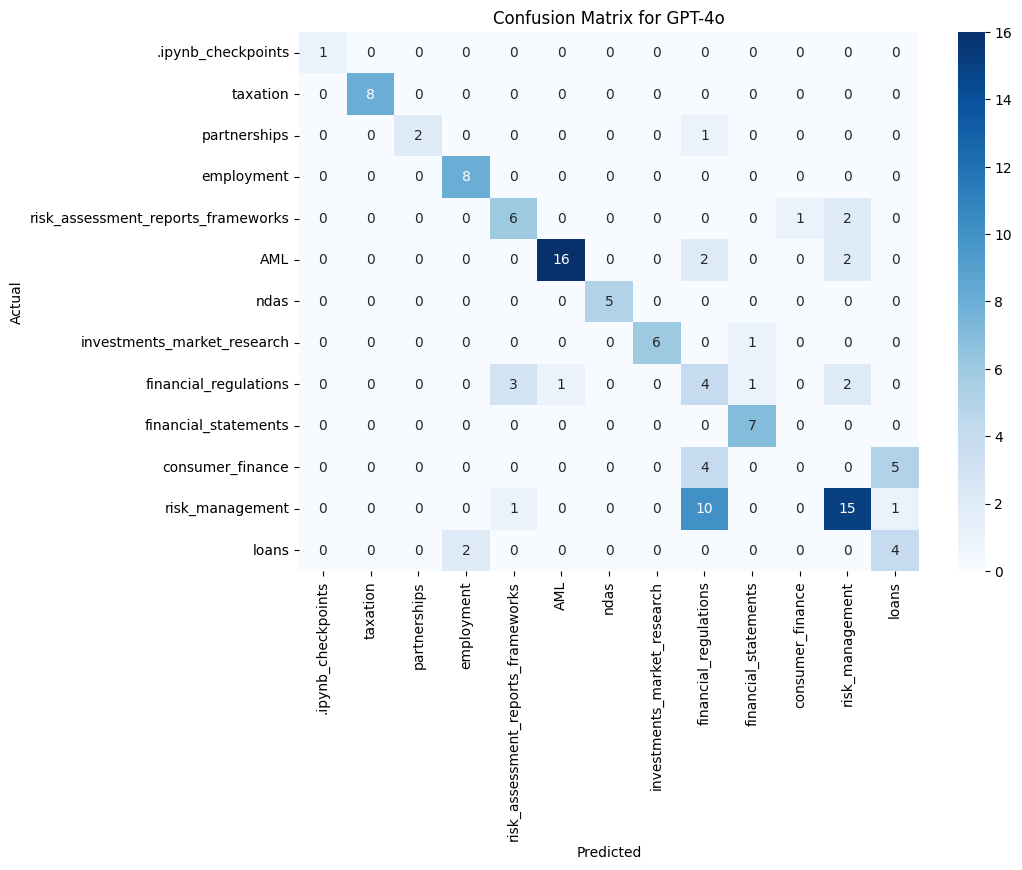

AWS Bedrock Llama Classification Report:
                                    precision    recall  f1-score   support

                .ipynb_checkpoints       1.00      1.00      1.00         1
                               AML       1.00      0.14      0.25        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.89      1.00      0.94         8
             financial_regulations       0.14      0.18      0.16        11
              financial_statements       0.70      1.00      0.82         7
       investments_market_research       1.00      0.86      0.92         7
                             loans       0.45      0.83      0.59         6
                              ndas       1.00      1.00      1.00         5
                      partnerships       1.00      0.67      0.80         3
risk_assessment_reports_frameworks       0.35      0.67      0.46         9
                   risk_management       0.54 

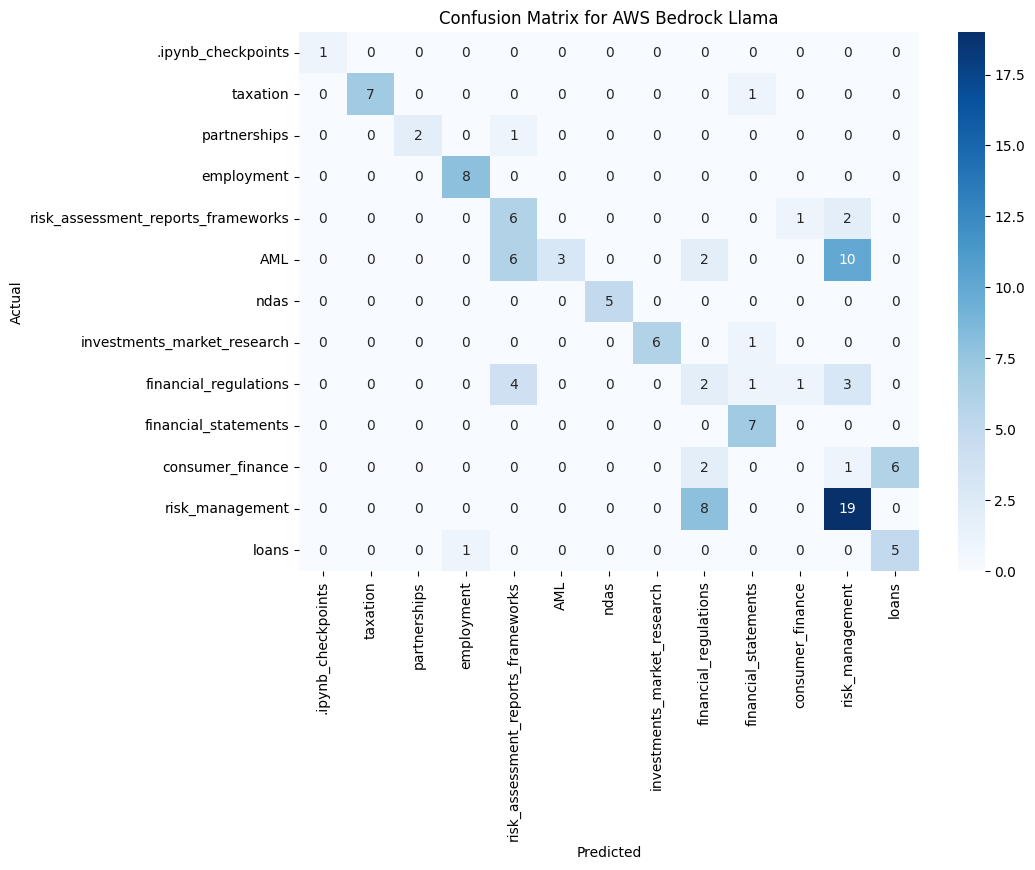

BERT Classification Report:
                                    precision    recall  f1-score   support

                .ipynb_checkpoints       0.00      0.00      0.00         1
                               AML       0.00      0.00      0.00        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.00      0.00      0.00         8
             financial_regulations       0.00      0.00      0.00        11
              financial_statements       0.00      0.00      0.00         7
       investments_market_research       0.00      0.00      0.00         7
                             loans       0.00      0.00      0.00         6
                              ndas       0.08      0.40      0.13         5
                      partnerships       0.00      0.00      0.00         3
risk_assessment_reports_frameworks       0.00      0.00      0.00         9
                   risk_management       0.00      0.00    

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


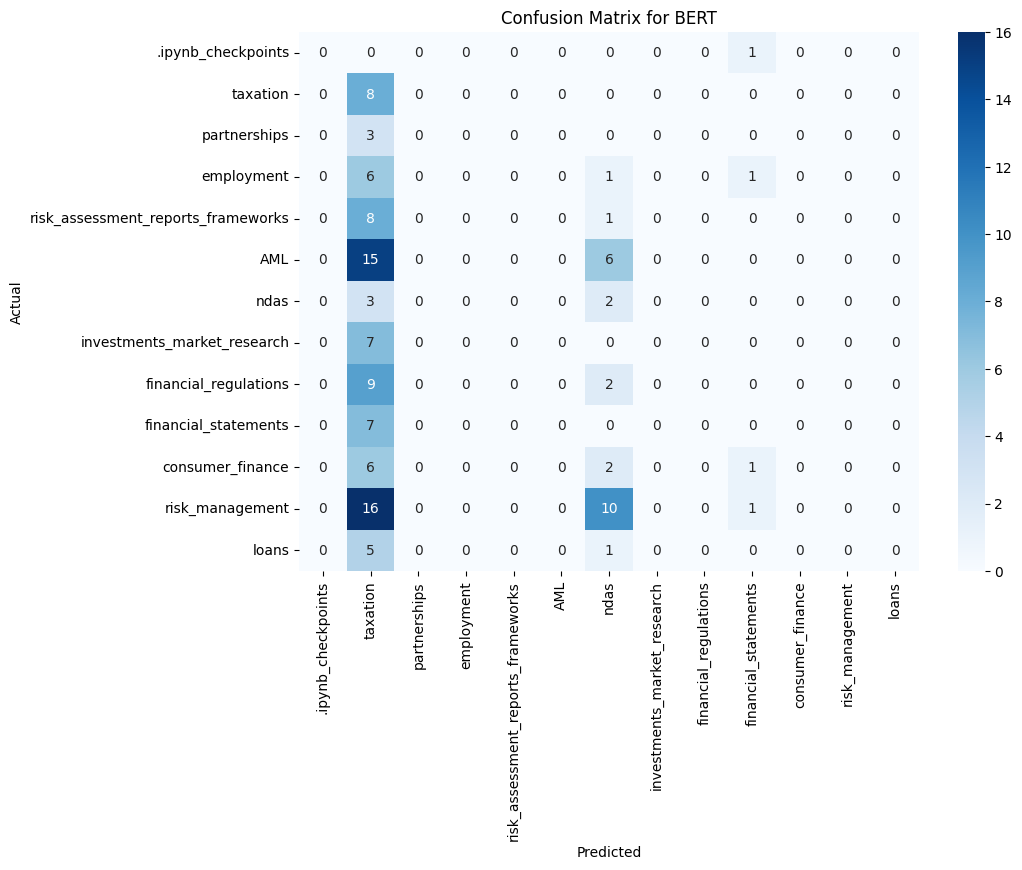

Longformer Classification Report:
                                    precision    recall  f1-score   support

                .ipynb_checkpoints       0.00      0.00      0.00         1
                               AML       0.00      0.00      0.00        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.00      0.00      0.00         8
             financial_regulations       0.00      0.00      0.00        11
              financial_statements       0.00      0.00      0.00         7
       investments_market_research       0.00      0.00      0.00         7
                             loans       0.00      0.00      0.00         6
                              ndas       0.00      0.00      0.00         5
                      partnerships       0.00      0.00      0.00         3
risk_assessment_reports_frameworks       0.00      0.00      0.00         9
                   risk_management       0.22      0.

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


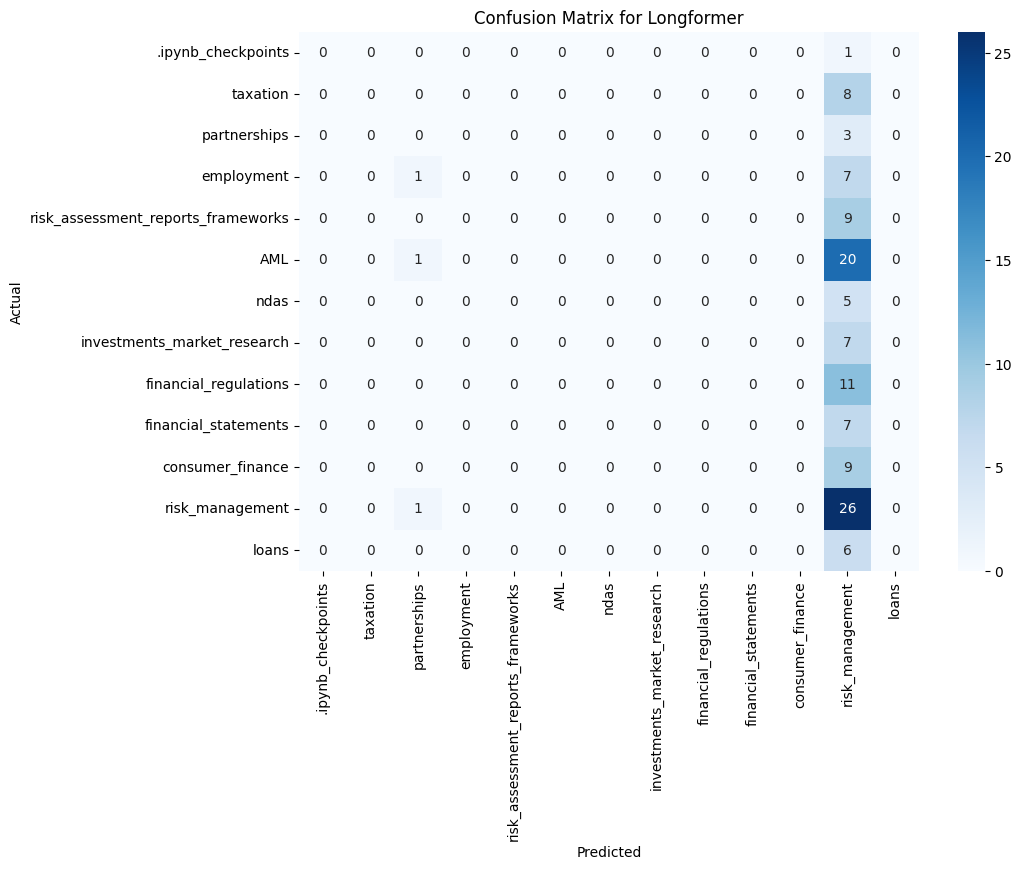

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification, LongformerTokenizer, LongformerForSequenceClassification
import torch
from torch.nn.functional import softmax
import os
import pandas as pd
import json
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from botocore.config import Config
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables
load_dotenv("codes.env")

# Set up AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")

# Create a Bedrock Runtime client
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# OpenAI client setup
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# Load the mapping CSV file
mapping_file_path = 'file_topic_mapping.csv'
data_folder_path = 'W2_Cleaned_Data'  # Root folder containing topic directories

# Load the file-topic mapping CSV
file_topic_mapping = pd.read_csv(mapping_file_path)

# Extract unique topics from the CSV
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# AWS Bedrock Llama Model Configuration
MODEL_ID = "arn:aws:bedrock:us-east-1:874280117166:inference-profile/us.meta.llama3-3-70b-instruct-v1:0"

# Function to read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Function to map verbose outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# Function to call OpenAI API for topic evaluation
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into one of these topics: {unique_topics_str}. \n{file_content}"},
            ],
            model="gpt-4o",
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# Function to call AWS Bedrock Llama model for topic evaluation
def evaluate_topic_with_aws_llama(file_content):
    try:
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body["generation"]
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Load BERT Tokenizer and Model
def load_bert_model():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(unique_topics))
    return tokenizer, model

# Load Longformer Tokenizer and Model
def load_longformer_model():
    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
    model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=len(unique_topics))
    return tokenizer, model

# Predict function for BERT with chunking
def evaluate_topic_with_bert(file_content, tokenizer, model):
    model.eval()
    chunk_size = 512  # Maximum token size for BERT
    overlap = 50      # Overlap between chunks to preserve context

    # Tokenize and chunk the input text
    tokens = tokenizer(file_content, truncation=False, return_tensors="pt")
    input_ids = tokens["input_ids"].squeeze()

    # Divide into chunks with overlap
    chunks = [
        input_ids[i:i + chunk_size]
        for i in range(0, len(input_ids), chunk_size - overlap)
    ]

    # Predict topic for each chunk
    logits_list = []
    with torch.no_grad():
        for chunk in chunks:
            chunk = chunk.unsqueeze(0)  # Add batch dimension
            outputs = model(chunk)
            logits_list.append(outputs.logits)

    # Aggregate logits across chunks
    aggregated_logits = torch.mean(torch.stack(logits_list), dim=0)
    predicted_label = torch.argmax(aggregated_logits, dim=1).item()
    return unique_topics[predicted_label]

# Predict function for Longformer
def evaluate_topic_with_longformer(file_content, tokenizer, model):
    model.eval()
    max_tokens = 4096  # Maximum token size for Longformer

    # Tokenize the input text
    tokens = tokenizer(file_content, truncation=True, max_length=max_tokens, return_tensors="pt")

    # Predict topic
    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
    return unique_topics[predicted_label]

# Initialize models
bert_tokenizer, bert_model = load_bert_model()
longformer_tokenizer, longformer_model = load_longformer_model()

# Extend the evaluate_files function to include BERT and Longformer
def evaluate_files():
    results = []

    for _, row in file_topic_mapping.iterrows():
        relative_path = row['file_name']  # Assuming column name is 'file_name'
        expected_topic = row['folder_name'].strip()  # Keep the original casing for topics

        file_path = os.path.join(data_folder_path, expected_topic, relative_path)

        # Read file content
        content = read_txt_file(file_path)
        if not content:
            continue

        # Evaluate topic using GPT-4o
        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)

        # Evaluate topic using AWS Bedrock Llama
        predicted_topic_llama = evaluate_topic_with_aws_llama(content)

        # Evaluate topic using BERT with chunking
        predicted_topic_bert = evaluate_topic_with_bert(content, bert_tokenizer, bert_model)

        # Evaluate topic using Longformer
        predicted_topic_longformer = evaluate_topic_with_longformer(content, longformer_tokenizer, longformer_model)

        # Append results
        results.append({
            'file_path': relative_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama,
            'predicted_topic_bert': predicted_topic_bert,
            'predicted_topic_longformer': predicted_topic_longformer
        })

        # Log mismatched results for debugging
        # if (predicted_topic_gpt4o != expected_topic or
        #         predicted_topic_llama != expected_topic or
        #         predicted_topic_bert != expected_topic or
        #         predicted_topic_longformer != expected_topic):
        #     print(f"MISMATCH: File: {relative_path}, Expected: {expected_topic}, GPT-4o: {predicted_topic_gpt4o}, Llama: {predicted_topic_llama}, BERT: {predicted_topic_bert}, Longformer: {predicted_topic_longformer}")

    return pd.DataFrame(results)

# Evaluate all files
results_df = evaluate_files()

# Save results to a CSV file
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

# Evaluate model performance
def evaluate_model_performance():
    print("Evaluating model performance...")
    expected_topics = results_df['expected_topic']
    
    models = {
        "GPT-4o": results_df['predicted_topic_gpt4o'],
        "AWS Bedrock Llama": results_df['predicted_topic_llama'],
        "BERT": results_df['predicted_topic_bert'],
        "Longformer": results_df['predicted_topic_longformer']
    }

    for model_name, predicted_topics in models.items():
        print(f"{model_name} Classification Report:")
        print(classification_report(expected_topics, predicted_topics))
        plot_confusion_matrix(expected_topics, predicted_topics, model_name)

evaluate_model_performance()

<Figure size 1200x800 with 0 Axes>

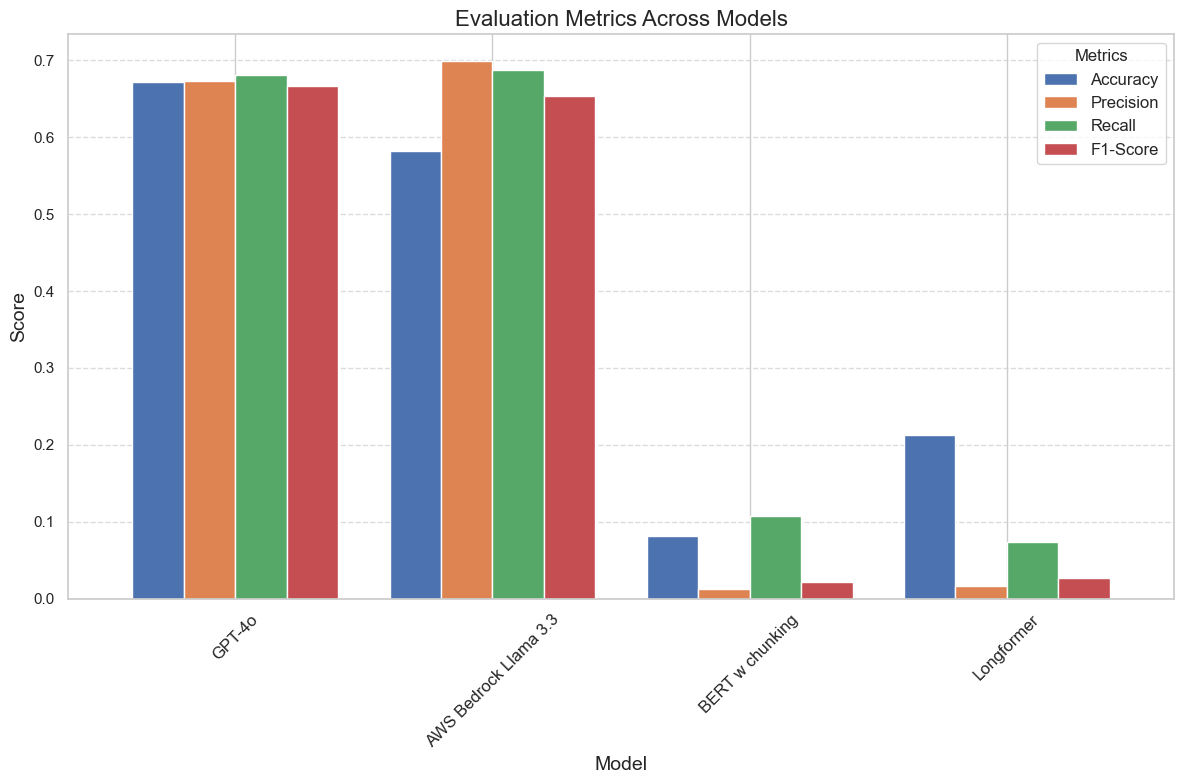

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Load results from the evaluation CSV file
results_df = pd.read_csv("topic_evaluation_results.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama", "predicted_topic_bert", "predicted_topic_longformer"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3", "BERT w chunking", "Longformer"]

# Initialize a DataFrame to hold evaluation metrics
metrics_data = []

# Calculate metrics for each model
for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df["expected_topic"], 
        results_df[model_column], 
        output_dict=True, 
        zero_division=0  # Avoid division by zero errors
    )
    
    # Extract overall metrics
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

# Create a DataFrame for visualization
metrics_df = pd.DataFrame(metrics_data)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for the metrics
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)

plt.title("Evaluation Metrics Across Models", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()